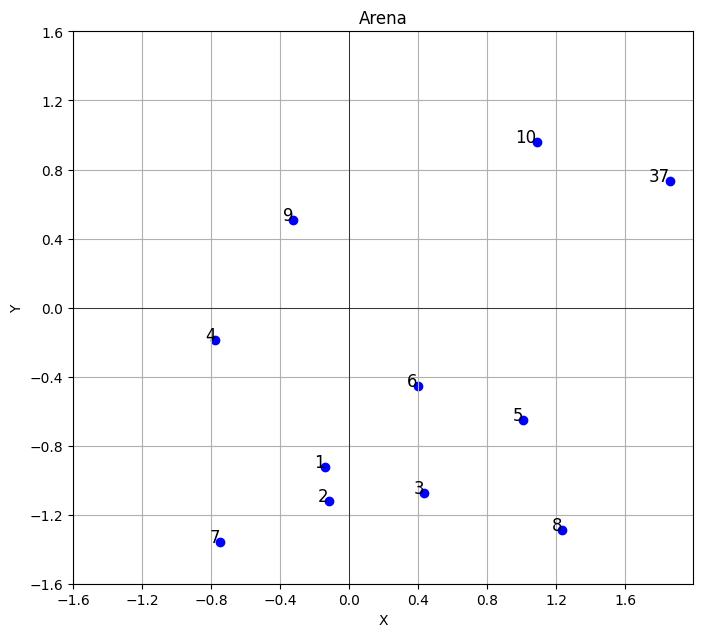

In [9]:
import matplotlib.pyplot as plt
import json

# Load the data from the JSON file
with open('lab_output/slam.txt', 'r') as file:
    aruco_map = json.load(file)

# Extract x and y coordinates
x_coords = [data['x'] for data in aruco_map.values()]
y_coords = [data['y'] for data in aruco_map.values()]

# Extract labels and modify to show only the numbers
labels = [label.split('_')[0].replace('aruco', '') for label in aruco_map.keys()]

# Create the plot
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, color='blue', marker='o')

# Annotate each point with the modified label (only the number)
for i, label in enumerate(labels):
    plt.text(x_coords[i], y_coords[i], label, fontsize=12, ha='right')

# Set plot labels and title
plt.title('Arena')
plt.xlabel('X')
plt.ylabel('Y')
ax = plt.gca()
ax.set_xticks([-1.6, -1.2, -0.8, -0.4, 0, 0.4, 0.8, 1.2, 1.6])
ax.set_yticks([-1.6, -1.2, -0.8, -0.4, 0, 0.4, 0.8, 1.2, 1.6])
plt.grid()
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


Final Transformation Parameters:
Rotation Angle: -5.0 degrees
Translation X: 0.04
Translation Y: 0.33
Transformed map saved to 'lab_output/slam_t.txt' with original labels.


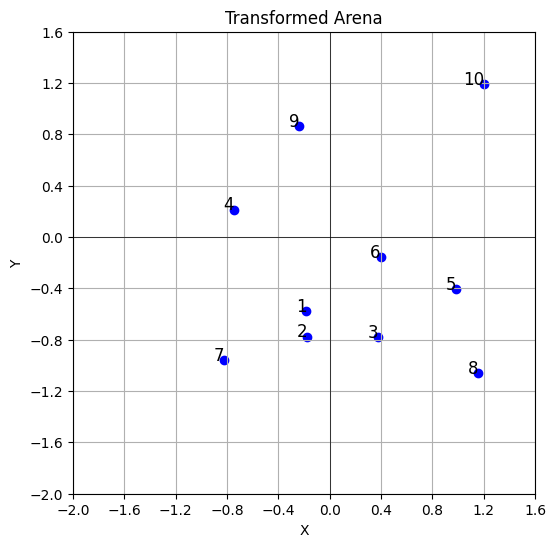

In [10]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
import tkinter as tk
import json

# Load the data from the JSON file
with open('lab_output/slam.txt', 'r') as file:
    aruco_map = json.load(file)

# Filter to include only ArUco markers with numbers in the range 0-10
filtered_map = {k: v for k, v in aruco_map.items() if 0 <= int(k.split('_')[0].replace('aruco', '')) <= 10}

# Extract x and y coordinates and labels from the filtered map
x_coords = np.array([data['x'] for data in filtered_map.values()])
y_coords = np.array([data['y'] for data in filtered_map.values()])
labels = [label.split('_')[0].replace('aruco', '') for label in filtered_map.keys()]

# Initialize transformation parameters
rotation_angle = 0
translation_x = 0
translation_y = 0

# Define a function to apply transformation and update the plot
def update_plot():
    global rotation_angle, translation_x, translation_y
    # Apply rotation
    cos_theta = np.cos(np.radians(rotation_angle))
    sin_theta = np.sin(np.radians(rotation_angle))
    rotation_matrix = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
    rotated_coords = np.dot(rotation_matrix, np.vstack((x_coords, y_coords)))

    # Apply translation
    transformed_x = rotated_coords[0, :] + translation_x
    transformed_y = rotated_coords[1, :] + translation_y

    # Update the plot
    ax.clear()
    ax.scatter(transformed_x, transformed_y, color='blue', marker='o')
    for i, label in enumerate(labels):
        ax.text(transformed_x[i], transformed_y[i], label, fontsize=12, ha='right')
    ax.set_title('Transformed Arena')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xticks(np.arange(-2, 2, 0.4))
    ax.set_yticks(np.arange(-2, 2, 0.4))
    ax.grid()
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.set_aspect('equal', adjustable='box')
    canvas.draw()

    global transformed_map
    transformed_map = {label: {"x": transformed_x[i], "y": transformed_y[i]} for i, label in enumerate(labels)}

# Initialize the Tkinter window
root = tk.Tk()
root.title("SLAM Map Transformation")

# Create the matplotlib figure and axes
fig, ax = plt.subplots(figsize=(6, 6))
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

# Create sliders for rotation and translation
# Create sliders for rotation and translation with finer resolution for translations
rotation_slider = tk.Scale(root, from_=-180, to=180, orient=tk.HORIZONTAL, label="Rotation Angle (degrees)",
                           command=lambda val: update_rotation(val))
rotation_slider.pack(fill=tk.X)

# Set translation sliders with finer resolution (0.01) for precise control
translation_x_slider = tk.Scale(root, from_=-2.0, to=2.0, resolution=0.01, orient=tk.HORIZONTAL,
                                label="Translation X", command=lambda val: update_translation_x(val))
translation_x_slider.pack(fill=tk.X)

translation_y_slider = tk.Scale(root, from_=-2.0, to=2.0, resolution=0.01, orient=tk.HORIZONTAL,
                                label="Translation Y", command=lambda val: update_translation_y(val))
translation_y_slider.pack(fill=tk.X)

# Slider update functions
def update_rotation(val):
    global rotation_angle
    rotation_angle = float(val)
    update_plot()

def update_translation_x(val):
    global translation_x
    translation_x = float(val)
    update_plot()

def update_translation_y(val):
    global translation_y
    translation_y = float(val)
    update_plot()

# Save the transformed map to 'slam_t.txt' with original labels concatenated back
def save_transformed_map():
    transformed_map_with_labels = {}
    
    # Iterate over the original labels and transformed coordinates
    for i, label in enumerate(labels):
        original_label = f"aruco{label}_0"  # Reconstruct the original label format
        transformed_x = transformed_map[label]["x"]
        transformed_y = transformed_map[label]["y"]
        
        # Add to the dictionary with the original label format
        transformed_map_with_labels[original_label] = {
            "x": transformed_x,
            "y": transformed_y
        }
    
    # Save the transformed map to the file with proper labels
    with open('lab_output/slam_t.txt', 'w') as file:
        json.dump(transformed_map_with_labels, file, indent=4)
    
    print("Transformed map saved to 'lab_output/slam_t.txt' with original labels.")

# Finalize transformation, print values, and save the map
def finalize_transformation():
    print("Final Transformation Parameters:")
    print(f"Rotation Angle: {rotation_angle} degrees")
    print(f"Translation X: {translation_x}")
    print(f"Translation Y: {translation_y}")
    
    # Save the transformed map to the file
    save_transformed_map()
    
    # Close the GUI
    root.quit()
    root.destroy()

# Add a button to finalize the transformation
finalize_button = tk.Button(root, text="Finalize Transformation", command=finalize_transformation)
finalize_button.pack()

# Initialize the plot with default values
update_plot()

# Run the Tkinter main loop
root.mainloop()
